# Pool-based Multilabel Active Learning - Birdset Example

> **_Google Colab Note:_** If the notebook fails to run after installing the needed packages, try to restart the runtime (Ctrl + M) under Runtime -> Restart session.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](<colab_link>)

In [1]:
# !pip install scikit-activeml
# !pip install datasets==2.21.0
# !pip install git+https://github.com/google-research/perch-hoplite.git  #chirp

This tutorial aims to demonstrate a practical comparison study using our `scikit-activeml` library in a multi-label classification task. The workflow involves utilizing a self-supervised learning model, specifically `Perch` from [1], to generate embeddings for the BirdSet dataset [2]. Subsequently, various active learning strategies will be employed to intelligently select samples for labeling.

**Key Steps:**
1. **Self-Supervised Learning Model:** Utilize the `Perch` model to create embedding dataset for BirdSet dataset.

2. **Active Learning Strategies:** Employ different active learning strategies provided by our library, including:
    - Random Sampling
    - Entropy Sampling
    - DropQuery
    - Badge
    - TypiClust
    - MMC (multi-label native)
    - LCI (multi-label native)

3. **Batch Sample Selection:** Use each active learning strategy to select a batch of samples for labeling.

4. **Plotting the results:** By the end of this notebook, we'll compare the accuracy of the aforementioned active learning strategies.

**References:**

[1] Ghani, B., Denton, T., Kahl, S., & Klinck, H. (2023). Global birdsong embeddings enable superior transfer learning for bioacoustic classification. Scientific Reports, 13.

[2] Rauch, L., Schwinger, R., Wirth, M., Heinrich, R., Huseljic, D., Herde, M., Lange, J., Kahl, S., Sick, B., Tomforde, S., & Scholz, C. (2024). BirdSet: A Large-Scale Dataset for Audio Classification in Avian Bioacoustics.

## Feature extraction with embedding model

In [2]:
from perch_hoplite.zoo.model_configs import load_model_by_name

In [6]:
from datasets import load_dataset, Audio
from tqdm.notebook import tqdm

import numpy as np
from os import makedirs
import matplotlib.pyplot as plt

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, average_precision_score

from skactiveml.classifier import SklearnMultilabelClassifier, SklearnClassifier
from skactiveml.pool import RandomSampling, UncertaintySampling, DropQuery, Badge, TypiClust, MMC, LabelCardinalityInconsistency
from skactiveml.utils import MISSING_LABEL, call_func

import warnings
warnings.filterwarnings("ignore")

In [7]:
def topk_accuracy(preds, targets, topk=1):
    """
    Compute the Top-K Accuracy for multi-class or multi-label predictions using NumPy.

    Args:
        preds (np.ndarray): Prediction probabilities of shape (N, C).
        targets (np.ndarray): One-hot encoded ground truth labels of shape (N, C).
        topk (int): Number of top predictions to consider.

    Returns:
        float: Top-K accuracy.
    """
    # Get the indices of the top-k predictions
    topk_pred_indices = np.argsort(-preds, axis=1)[:, :topk]

    # Convert one-hot encoded targets to indices for positive cases
    correct_positive = np.any(targets[np.arange(targets.shape[0])[:, None], topk_pred_indices], axis=1)

    # Combine correct predictions
    correct = correct_positive.sum()

    # Determine total number of samples to consider
    total = len(targets)

    # Compute accuracy
    accuracy = correct / total if total > 0 else 0.0

    return accuracy

### Setup Perch embedding model
[Perch](https://www.kaggle.com/models/google/bird-vocalization-classifier/tensorFlow2/bird-vocalization-classifier) is a state-of-the-art deep learning model for bird call classification, developed by Google. It is one of the top-performing models in this domain.

In this tutorial, we utilize the official Perch [package](https://github.com/google-research/perch), which handles all the preprocessing of audio data. The package allows us to embed audio recordings into a latent space, making them ready for further processing during the active learning workflow.

In [8]:
model = load_model_by_name("perch_8")

In [9]:
def embed_audio_one_hot(data, num_classes, model):
    """
    Designed to be used as a mapping function for a birdset huggingface dataset.
    Calculating the features of the audio and one-hot encoding the target

    Parameters:
    - data (dict) : containing individual rows of the dataset as a dictionary
    - num_classes (int) : total number of classes, for the one-hot encoding of labels
    - model : model implementing an embed function to calculate embedding for a given audio

    Returns:
    - data (dict): original data with appended "embedding" and "onehot" entry
    """
    labels = data["ebird_code_multilabel"]
    output = model.embed(data["audio"]["array"])

    # one hot encode
    onehot = np.zeros(shape=num_classes)
    for label in labels:
        onehot[label] = 1

    data["embedding"] = output.embeddings.squeeze()
    data["onehot"] = onehot
    return data

### Birdset Dataset
The Birdset dataset consists of nine bird call classification tasks, each designed with varying levels of difficulty.

Each task includes multiple audio recordings collected from specific geographical regions, capturing the intricate and diverse nature of bird chirps. The audio samples are recorded at a sampling rate of 32 kHz and segmented into timeframes of up to 5 seconds. The goal of each task is to identify all bird species whose calls are present within a given timeframe.

In this tutorial, we focus on the NBP task, which is the smallest among the nine tasks. It contains 539 5-second timeframes and spans a total of 51 bird species (classes).

Below is the code for loading the dataset from [Huggingface](https://huggingface.co/datasets/DBD-research-group/BirdSet) and some examples.

In [11]:
birdset_name = "NBP_scape"
makedirs("data/", exist_ok=True)
dataset = load_dataset(
    path="DBD-research-group/BirdSet",
    name=birdset_name,
    trust_remote_code=True,
    cache_dir="data/NBP_scape"
)

dataset = dataset.cast_column("audio", Audio(decode=True, sampling_rate=32_000))
dataset.set_format("np")

num_classes = len(dataset["test"].features["ebird_code"].names)
dataset["test_5s"] = dataset["test_5s"].map(embed_audio_one_hot, batched=False, cache_file_name=f"{birdset_name}_cached_mapping", fn_kwargs={"num_classes": num_classes, "model": model})

Map:   0%|          | 0/539 [00:00<?, ? examples/s]

In [12]:
from IPython.display import Audio
print("ebird code of birds in audio:", dataset["test_5s"].features["ebird_code_multilabel"].feature.int2str(dataset["test_5s"][2]["ebird_code_multilabel"]))
Audio(dataset["test_5s"][2]["audio"]["array"], rate=32000)

ebird code of birds in audio: ['easwar1', 'rocpet1']


In [13]:
print("ebird code of birds in audio:", dataset["test_5s"].features["ebird_code_multilabel"].feature.int2str(dataset["test_5s"][5]["ebird_code_multilabel"]))
Audio(dataset["test_5s"][5]["audio"]["array"], rate=32000)

ebird code of birds in audio: ['coatit2', 'eurjay1', 'comcha', 'eurbla', 'eurnut2']


In [14]:
# extract 80% of the data for training and 20% for testing
l = len(dataset["test_5s"])
X = dataset["test_5s"][:int(0.8 * l)]["embedding"]
Y_true = dataset["test_5s"][:int(0.8 * l)]["onehot"]

X_test = dataset["test_5s"][int(0.8 * l):]["embedding"]
Y_test = dataset["test_5s"][int(0.8 * l):]["onehot"]

### Active Learning Cycle Setup
Here we configure the parameters for the active learning cycle. This includes settings for the number of cycles (`n_cycles`), the random seed (`seed`), and the batch size (`batch_size`) for annotated instances.

Additionally, we select a set of active learning strategies to evaluate and apply a `SubSamplingWrapper`. This wrapper limits the optimization process to a subset of 5,000 instances, improving computational efficiency while maintaining nearly perfect performance.

In [15]:
# parameter setup
seed = 0
n_cycles = 20
batch_size = 20

In [16]:
strategies = {
    "Random": RandomSampling(random_state=seed),
    "Entropy_sum": UncertaintySampling(random_state=seed, ml_agg=np.nansum),
    "Entropy_max": UncertaintySampling(random_state=seed, ml_agg=np.max),
    "DropQuery_sum": DropQuery(random_state=seed, n_dropout_samples=20, multilabel_aggregation_fn=np.sum),
    "DropQuery_max": DropQuery(random_state=seed, n_dropout_samples=20, multilabel_aggregation_fn=np.max),
    "Badge": Badge(random_state=seed),
    "Typiclust": TypiClust(random_state=seed),
    "MMC": MMC(random_state=seed),
    "LCI": LabelCardinalityInconsistency(random_state=seed),
}

In [26]:
history_t1 = {name: [] for name in strategies.keys()}
history_f1 = {name: [] for name in strategies.keys()}

for name, qs in strategies.items():
    clf = SklearnMultilabelClassifier(MultiOutputClassifier(LogisticRegression(random_state=0, n_jobs=-1, max_iter=500), n_jobs=-1), classes=np.arange(Y_true.shape[-1]), random_state=0)
    discriminator = SklearnClassifier(LogisticRegression())

    Y = np.full(shape=Y_true.shape, fill_value=MISSING_LABEL)
    clf.fit(X, Y)
    history_t1[name].append(topk_accuracy(clf.predict(X_test), Y_test))
    history_f1[name].append(f1_score(clf.predict(X_test), Y_test, average="micro"))
    for c in tqdm(range(n_cycles), desc=name):
        query_idx = call_func(qs.query, X=X, y=Y, discriminator=discriminator, clf=clf, fit_clf=False, batch_size=batch_size)

        Y[query_idx] = Y_true[query_idx]
        clf.fit(X, Y)

        history_t1[name].append(topk_accuracy(clf.predict(X_test), Y_test))
        history_f1[name].append(f1_score(clf.predict(X_test), Y_test, average="micro"))

Random:   0%|          | 0/20 [00:00<?, ?it/s]

Entropy_sum:   0%|          | 0/20 [00:00<?, ?it/s]

Entropy_max:   0%|          | 0/20 [00:00<?, ?it/s]

DropQuery_sum:   0%|          | 0/20 [00:00<?, ?it/s]

DropQuery_max:   0%|          | 0/20 [00:00<?, ?it/s]

Badge:   0%|          | 0/20 [00:00<?, ?it/s]

Typiclust:   0%|          | 0/20 [00:00<?, ?it/s]

MMC:   0%|          | 0/20 [00:00<?, ?it/s]

LCI:   0%|          | 0/20 [00:00<?, ?it/s]

### NBP results

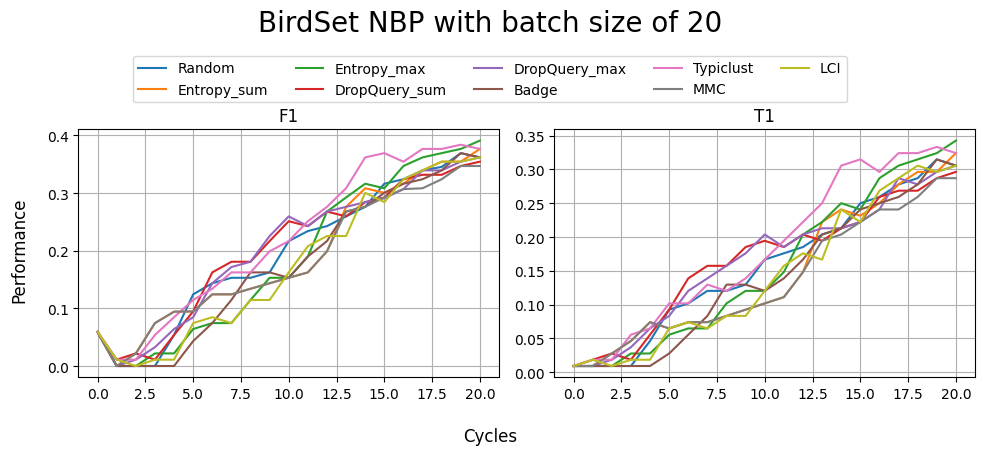

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, tight_layout=True)
histories = {"F1": history_f1, "T1": history_t1}
for ax, (metric, history) in zip(axes, histories.items()):
    for name, hist in history.items():
        ax.plot(range(0, n_cycles+1), hist, label=name)
    ax.set_title(metric)
    ax.grid(True)
fig.legend(*axes[0].get_legend_handles_labels(), loc="upper center", bbox_to_anchor=(0.5, 1), ncol=5)
fig.suptitle(f"BirdSet NBP with batch size of {batch_size}", size=20, y=1.1)
fig.supylabel("Performance")
fig.supxlabel("Cycles")
plt.show()